## Kaggle 比赛：树叶分类

数据下载地址：https://www.kaggle.com/c/classify-leaves/data

在开始之前，我们先看看数据集长什么样子：
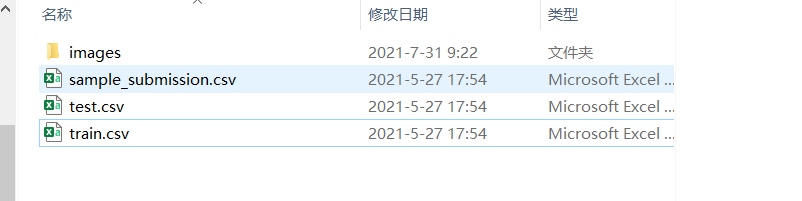
其中.csv中存放的是图片的地址和对应的标签

首先我们读取一下.csv中的数据，看看长什么样子：

In [2]:
import pandas as pd
import numpy as np
import torchvision

In [2]:
train_data = pd.read_csv(r"../data/classify-leaves/train.csv") # 训练数据
test_data = pd.read_csv(r"../data/classify-leaves/test.csv") # 测试数据
print(train_data.shape)
print(test_data.shape)
train_data # 训练数据有标签

(18353, 2)
(8800, 1)


,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera
...,...,...
18348,images/18348.jpg,aesculus_glabra
18349,images/18349.jpg,liquidambar_styraciflua
18350,images/18350.jpg,cedrus_libani
18351,images/18351.jpg,prunus_pensylvanica


In [3]:
test_data # 测试数据没有标签

,image
0,images/18353.jpg
1,images/18354.jpg
2,images/18355.jpg
3,images/18356.jpg
4,images/18357.jpg
...,...
8795,images/27148.jpg
8796,images/27149.jpg
8797,images/27150.jpg
8798,images/27151.jpg


然后我们将图片取出来,转换为tensor

In [4]:
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt


# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# loader使用torchvision中自带的transforms函数
loader = transforms.Compose([transforms.ToTensor()]) # 加载图片为tensor
 
unloader = transforms.ToPILImage() # tensor转换为PIL图片

# 输入图片地址
# 返回tensor变量
def image_loader(image_name):
  image = Image.open(image_name).convert('RGB')
  image = loader(image).unsqueeze(0) # batch维度
  return image.to(torch.float)


# 输入PIL格式图片
# 返回tensor变量
def PIL_to_tensor(image):
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

# 输入tensor变量
# 输出PIL格式图片
def tensor_to_PIL(tensor):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  return image

# 直接展示tensor格式图片
def imshow(tensor, title=None):
  image = tensor.cpu().clone() # we clone the tensor to not do changes on it
  image = image.squeeze(0) # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

测试一下，写的图片转换为tensor的函数

torch.float32
torch.Size([1, 3, 224, 224])


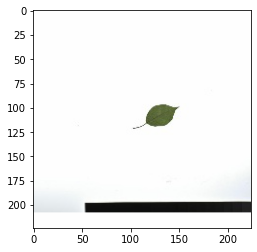

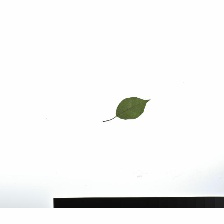

In [8]:
train_demo = image_loader(r"../data/classify-leaves/"+train_data["image"][0])
print(train_demo.dtype) # torch.float32：表示转换成功
print(train_demo.shape)

imshow(train_demo) # 将tensor图片直接展示出来
tensor_to_PIL(train_demo) # 输出PIL格式图片

In [15]:
train_imgs = torchvision.datasets.ImageFolder(r"..\data\classify-leaves")
train_imgs[27151][1]

0

# 1、LeNet实现：

In [ ]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28) # [B, C, H, W]

# LeNet的实现：
net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(), # Flatten()就是第一维的批量不变，后面的拉成一个向量
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))